In [1]:
from functools import partial
from multiprocessing import Pool
from typing import Tuple, Union

import numpy as np
import torch

from pyvrp import (
    Model,
    Client,
    CostEvaluator,
    Depot,
    ProblemData,
    RandomNumberGenerator,
    Solution,
    VehicleType,
)
from pyvrp.search import (
    NODE_OPERATORS,
    ROUTE_OPERATORS,
    LocalSearch,
    NeighbourhoodParams,
    compute_neighbours,
)
from pyvrp.stop import MaxRuntime
from tensordict.tensordict import TensorDict

from rl4co.utils.ops import get_distance_matrix
from rl4co.utils.pylogger import get_pylogger
from rl4co.models.zoo import DeepACO

C:\Users\zm0714\Documents\Projekte\rl4co-slap\venv\Lib\site-packages\torchrl\data\replay_buffers\samplers.py:37: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. If you installed TorchRL from PyPI, please report the bug on TorchRL github. If you installed TorchRL locally and/or in development mode, check that you have all the required compiling packages.
  warnings.warn(EXTENSION_WARNING)


In [2]:
def read_instance(file_path):
    instance = {
        'nodes': [],
        'vehicletypes': [],
        'arcs': [],
        'num_nodes': 0  # We'll determine this based on the NODES section
    }

    with open(file_path, 'r') as f:
        section = None
        
        for line in f:
            line = line.strip()

            # Skip empty lines
            if not line:
                continue

            # Identify the sections
            if line.startswith('NODES'):
                instance['num_nodes'] = int(line.split()[1])  # Extract number of nodes
                section = 'nodes'
                continue
            elif line.startswith('VEHICLETYPES'):
                section = 'vehicletypes'
                continue
            elif line.startswith('ARCS'):
                section = 'arcs'
                continue

            # Parse nodes section
            if section == 'nodes':
                parts = line.split()
                if len(parts) == 5:
                    node = {
                        'type': parts[0],      # Node type (d, f, c)
                        'id': int(parts[1]),   # Node id
                        'demand': int(parts[2]), # Demand
                        'earliest': int(parts[3]), # Earliest time
                        'latest': int(parts[4])  # Latest time
                    }
                    instance['nodes'].append(node)

            # Parse vehicle types section
            elif section == 'vehicletypes':
                parts = line.split()
                if len(parts) == 7:
                    vehicle = {
                        'start_node': int(parts[0]), # Start node id
                        'end_node': int(parts[1]),   # End node id
                        'Hmax': int(parts[2]),       # Maximum capacity
                        'Hinit': int(parts[3]),      # Initial capacity
                        'Hfinal': int(parts[4]),     # Final capacity
                        'capacity': int(parts[5]),   # Vehicle capacity
                        'num_vehicles': int(parts[6]) # Number of vehicles
                    }
                    instance['vehicletypes'].append(vehicle)

            # Parse arcs section
            elif section == 'arcs':
                parts = line.split()
                if len(parts) == 5:
                    arc = {
                        'tail': int(parts[0]),   # Tail node id
                        'head': int(parts[1]),   # Head node id
                        'cost': int(parts[2]),   # Cost
                        'time': int(parts[3]),   # Time
                        'energy': int(parts[4])  # Energy consumption
                    }
                    instance['arcs'].append(arc)
    
    # Create the cost, time, and energy matrices
    num_nodes = instance['num_nodes']
    cost_matrix = np.full((num_nodes, num_nodes), 0.0)  # Initialize with infinity (no direct path)
    time_matrix = np.full((num_nodes, num_nodes), 0.0)  # Same for time
    energy_matrix = np.full((num_nodes, num_nodes), 0.0)  # Same for energy
    
    factor = 100
    # Fill the matrices with values from the arcs
    for arc in instance['arcs']:
        tail = arc['tail']
        head = arc['head']
        cost_matrix[tail][head] = arc['cost'] #/ 100
        time_matrix[tail][head] = arc['time'] #/ 100
        energy_matrix[tail][head] = arc['energy'] #/ 100

    return instance, cost_matrix, time_matrix, energy_matrix

# Example usage
instance, cost_matrix, time_matrix, energy_matrix = read_instance('./ejor/ejor/instances/karis/karis_S_empty_fast_1_100.inst')

# Access matrices
print("Cost Matrix:\n", cost_matrix)
print("Time Matrix:\n", time_matrix)
print("Energy Matrix:\n", energy_matrix)

Cost Matrix:
 [[  0. 558. 523. 611. 590. 554. 341. 368. 396. 423. 451. 479. 385.   0.
    0.   0.   0. 341. 368. 396. 423.]
 [613.   0. 557. 645. 623. 588. 374. 347. 374. 402. 429. 457. 419.   0.
    0.   0.   0. 374. 347. 374. 402.]
 [634. 612.   0. 665. 644. 609. 395. 367. 340. 367. 395. 422. 440.   0.
    0.   0.   0. 395. 367. 340. 367.]
 [777. 755. 720.   0. 786. 751. 537. 510. 482. 455. 482. 510. 582.   0.
    0.   0.   0. 537. 510. 482. 455.]
 [810. 789. 754. 842.   0. 785. 571. 543. 516. 488. 461. 488. 616.   0.
    0.   0.   0. 571. 543. 516. 488.]
 [831. 809. 774. 862. 841.   0. 592. 564. 536. 509. 481. 454. 637.   0.
    0.   0.   0. 592. 564. 536. 509.]
 [341. 362. 397. 598. 577. 542.   0. 607. 635. 663. 690. 718. 538.   0.
    0.   0.   0. 580. 607. 635. 663.]
 [368. 347. 381. 583. 561. 526. 564.   0. 619. 647. 675. 702. 522.   0.
    0.   0.   0. 564. 592. 619. 647.]
 [396. 374. 340. 541. 519. 484. 522. 550.   0. 605. 633. 660. 480.   0.
    0.   0.   0. 522. 550. 578. 60

In [3]:
time_matrix

array([[  0., 558., 523., 611., 590., 554., 341., 368., 396., 423., 451.,
        479., 385.,   0.,   0.,   0.,   0., 341., 368., 396., 423.],
       [613.,   0., 557., 645., 623., 588., 374., 347., 374., 402., 429.,
        457., 419.,   0.,   0.,   0.,   0., 374., 347., 374., 402.],
       [634., 612.,   0., 665., 644., 609., 395., 367., 340., 367., 395.,
        422., 440.,   0.,   0.,   0.,   0., 395., 367., 340., 367.],
       [777., 755., 720.,   0., 786., 751., 537., 510., 482., 455., 482.,
        510., 582.,   0.,   0.,   0.,   0., 537., 510., 482., 455.],
       [810., 789., 754., 842.,   0., 785., 571., 543., 516., 488., 461.,
        488., 616.,   0.,   0.,   0.,   0., 571., 543., 516., 488.],
       [831., 809., 774., 862., 841.,   0., 592., 564., 536., 509., 481.,
        454., 637.,   0.,   0.,   0.,   0., 592., 564., 536., 509.],
       [341., 362., 397., 598., 577., 542.,   0., 607., 635., 663., 690.,
        718., 538.,   0.,   0.,   0.,   0., 580., 607., 635., 663.],

In [4]:
from rl4co.envs.routing.evrptw.generator import EVRPGenerator
from rl4co.envs.routing.evrptw.env import EVRPEnv

In [5]:
from rl4co.models import MatNetPolicy, MatNet, PPO, AttentionModel, POMO, AttentionModelPolicy

if torch.cuda.is_available():
    accelerator = "gpu"
    batch_size = 256
    train_data_size = 10_000
    embed_dim = 128
    num_encoder_layers = 4
else:
    accelerator = "cpu"
    batch_size = 16
    train_data_size = 10_000
    embed_dim = 128
    num_encoder_layers = 2
    
env = EVRPEnv(generator_params={"n_customers": 12, "min_num_agents": 4, "max_num_agents": 4, "dmat_only": True})

policy = MatNetPolicy()
model = MatNet(env=env,
               policy=policy,
               baseline="shared",
               batch_size=batch_size,
               train_data_size=train_data_size,
               val_data_size=2_000)
# model = DeepACO(
#         env,
#         train_data_size=500,
#         val_data_size=200,
#         test_data_size=10,
#         policy_kwargs={"n_ants": 5, "train_with_local_search": False},
#         
#     )
# policy = AttentionModelPolicy(env_name=env.name,
#                                   # this is actually not needed since we are initializing the embeddings!
#                                   embed_dim=128,
#                                   # init_embedding=MTSPInitEmbedding(emb_dim),
#                                   # context_embedding=MTSPContext(emb_dim),
#                                   # dynamic_embedding=StaticEmbedding(emb_dim)
#                                   )
# model = AttentionModel(env,
#                            baseline='rollout',
#                            policy=policy,
#                            train_data_size=10_000,  # really small size for demo
#                            val_data_size=10_000)

Found 4 unused kwargs: {'embed_dim': 256, 'num_encoder_layers': 5, 'num_heads': 16, 'normalization': 'instance'}
C:\Users\zm0714\Documents\Projekte\rl4co-slap\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
C:\Users\zm0714\Documents\Projekte\rl4co-slap\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


In [6]:
td_init = env.reset(batch_size=[4])

In [18]:
from rl4co.utils import RL4COTrainer

trainer = RL4COTrainer(max_epochs=3, devices="auto")
trainer.fit(model)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead

  | Name     | Type           | Params | Mode 
----------------------------------------------------
0 | env      | EVRPEnv        | 0      | train
1 | policy   | MatNetPolicy   | 5.8 M  | train
2 | baseline | SharedBaseline | 0      | train
----------------------------------------------------
5.8 M     Trainable params
0         Non-trainable params
5.8 M     Total params
23.189    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [19]:
out = model.policy(td_init.clone(), env, phase="test", decode_type="beam_search", return_actions=True)
print(out["reward"])

tensor([-17.7555, -12.2990,  -8.6721, -13.8926])


Agent 1: (-3, 0.5) -> (1.5, 0.0) in 1.8462053537368774
Agent 1: (1.5, 0.0) -> (0.5, -1.5) in 1.294377326965332
Agent 1: (0.5, -1.5) -> (-1.5, 1.5) in 1.4513291120529175
Agent 1: (-1.5, 1.5) -> (1.5, -1.5) in 1.0812429189682007
Agent 1: (1.5, -1.5) -> (0.5, 1.5) in 1.8095908164978027
Agent 1: (0.5, 1.5) -> (-1.5, 0.0) in 1.803817868232727
Agent 1: (-1.5, 0.0) -> (1.5, 1.5) in 1.4731910228729248
Agent 1: (1.5, 1.5) -> (-0.5, -1.5) in 1.6954057216644287
Agent 1: (-0.5, -1.5) -> (0, 3.0) in 1.0090694427490234
Agent 1: (0, 3.0) -> (3, 0.5) in 1.2912814617156982
Agent 2: (-3, 0.0) -> (0.5, 0.0) in 1.913841962814331
Agent 2: (0.5, 0.0) -> (3, 0.0) in 1.1612021923065186
Agent 3: (-3, -0.5) -> (-1.5, -1.5) in 1.367806077003479
Agent 3: (-1.5, -1.5) -> (3, -0.5) in 1.048958659172058
Agent 4: (-3, -1.0) -> (-0.5, 0.0) in 1.407441258430481
Agent 4: (-0.5, 0.0) -> (-0.5, 1.5) in 1.5239512920379639
Agent 4: (-0.5, 1.5) -> (3, -1.0) in 1.0208539962768555
tensor(14.7555)
{1: 1, 2: 0, 3: 0, 4: 0}
{1: [

C:\Users\zm0714\AppData\Local\Temp\ipykernel_29108\1602695519.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


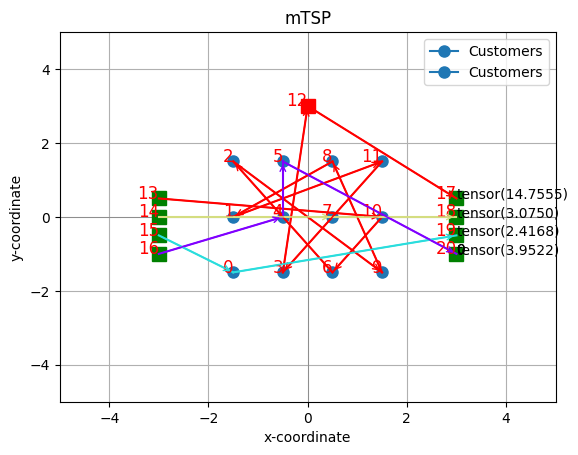

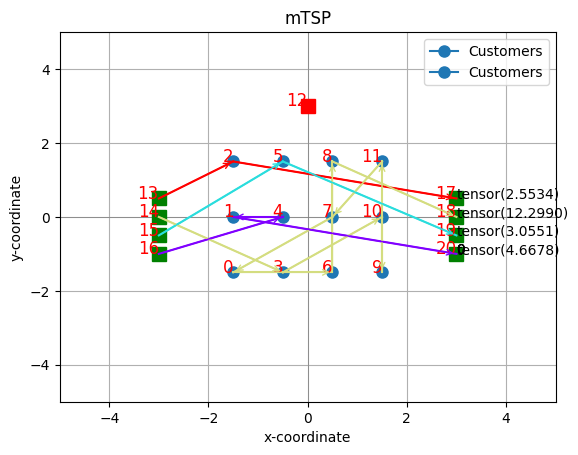

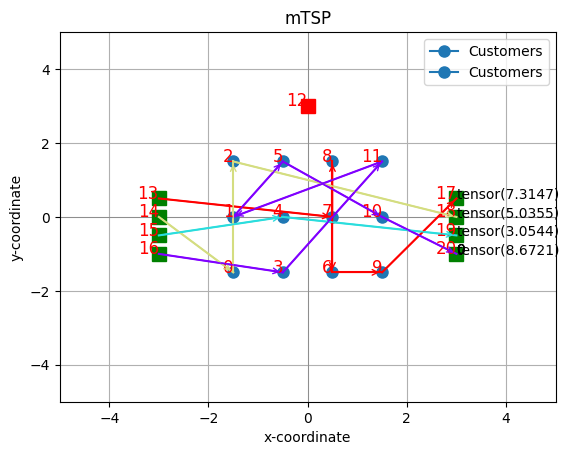

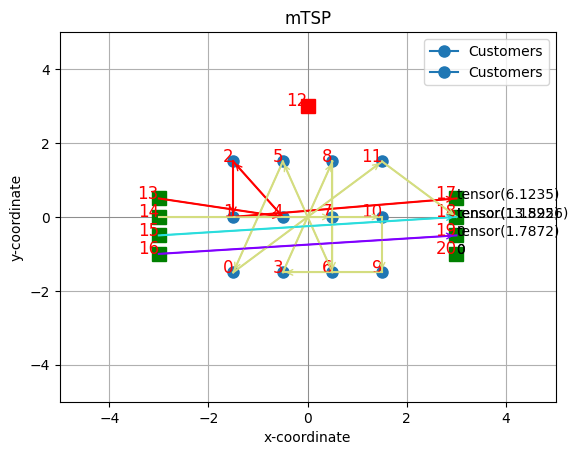

In [20]:
for td, actions in zip(td_init, out['actions'].cpu()):
    fig = env.render(td, actions)
    fig.show()

In [6]:
# Utils function
def normalize_coord(coord:torch.Tensor) -> torch.Tensor:
    x, y = coord[:, 0], coord[:, 1]
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    
    x_scaled = (x - x_min) / (x_max - x_min) 
    y_scaled = (y - y_min) / (y_max - y_min)
    coord_scaled = torch.stack([x_scaled, y_scaled], dim=1)
    return coord_scaled 

In [7]:
cost_matrix

array([[  0., 558., 523., 611., 590., 554., 341., 368., 396., 423., 451.,
        479., 385.,   0.,   0.,   0.,   0., 341., 368., 396., 423.],
       [613.,   0., 557., 645., 623., 588., 374., 347., 374., 402., 429.,
        457., 419.,   0.,   0.,   0.,   0., 374., 347., 374., 402.],
       [634., 612.,   0., 665., 644., 609., 395., 367., 340., 367., 395.,
        422., 440.,   0.,   0.,   0.,   0., 395., 367., 340., 367.],
       [777., 755., 720.,   0., 786., 751., 537., 510., 482., 455., 482.,
        510., 582.,   0.,   0.,   0.,   0., 537., 510., 482., 455.],
       [810., 789., 754., 842.,   0., 785., 571., 543., 516., 488., 461.,
        488., 616.,   0.,   0.,   0.,   0., 571., 543., 516., 488.],
       [831., 809., 774., 862., 841.,   0., 592., 564., 536., 509., 481.,
        454., 637.,   0.,   0.,   0.,   0., 592., 564., 536., 509.],
       [341., 362., 397., 598., 577., 542.,   0., 607., 635., 663., 690.,
        718., 538.,   0.,   0.,   0.,   0., 580., 607., 635., 663.],

In [12]:
from einops import repeat

env = EVRPEnv(generator_params={"n_customers": 12, "min_num_agents": 4, "max_num_agents": 4, "h_init": 0.781, "dmat_only": True})

batch_size = 2
td_eval = env.reset(batch_size=[batch_size]).to("cpu")
cm = torch.tensor(cost_matrix).float() / 1000
em = torch.tensor(energy_matrix).float() / 1000
td_eval["cost_matrix"] = repeat(cm, 'n d -> b n d', b=batch_size, d=td_eval["cost_matrix"].shape[1])
td_eval["energy_consumption"] = repeat(em, 'n d -> b n d', b=batch_size, d=td_eval["cost_matrix"].shape[1]) 

In [8]:
out = policy(td_eval.clone(), env, phase="test", decode_type="beam_search", return_actions=True)
print(out["reward"])

tensor([-75.5300, -74.7400])


tensor([10, 12,  0,  5, 11, 12,  3,  6,  1, 12,  4,  7,  2, 12,  8, 17, 12, 18,
        12, 19, 12,  9, 20])
Agent 1: (-3, 0.5) -> (1.5, 0.0) in 1.1100000143051147
Agent 1: (1.5, 0.0) -> (0, 3.0) in 6.679999828338623
Agent 1: (0, 3.0) -> (-1.5, -1.5) in 1.9800000190734863
Agent 1: (-1.5, -1.5) -> (-0.5, 1.5) in 5.539999961853027
Agent 1: (-0.5, 1.5) -> (1.5, 1.5) in 4.539999961853027
Agent 1: (1.5, 1.5) -> (0, 3.0) in 6.260000228881836
Agent 1: (0, 3.0) -> (-0.5, -1.5) in 2.2899999618530273
Agent 1: (-0.5, -1.5) -> (0.5, -1.5) in 5.369999885559082
Agent 1: (0.5, -1.5) -> (-1.5, 0.0) in 3.619999885559082
Agent 1: (-1.5, 0.0) -> (0, 3.0) in 4.190000057220459
Agent 1: (0, 3.0) -> (-0.5, 0.0) in 2.0799999237060547
Agent 1: (-0.5, 0.0) -> (0.5, 0.0) in 5.429999828338623
Agent 1: (0.5, 0.0) -> (-1.5, 1.5) in 3.809999942779541
Agent 1: (-1.5, 1.5) -> (0, 3.0) in 4.400000095367432
Agent 1: (0, 3.0) -> (0.5, 1.5) in 1.0099999904632568
Agent 1: (0.5, 1.5) -> (3, 0.5) in 5.21999979019165
Agent 2:

C:\Users\zm0714\AppData\Local\Temp\ipykernel_30576\2546779990.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


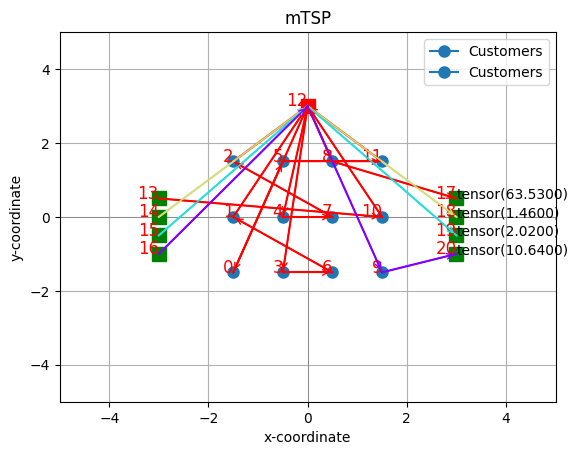

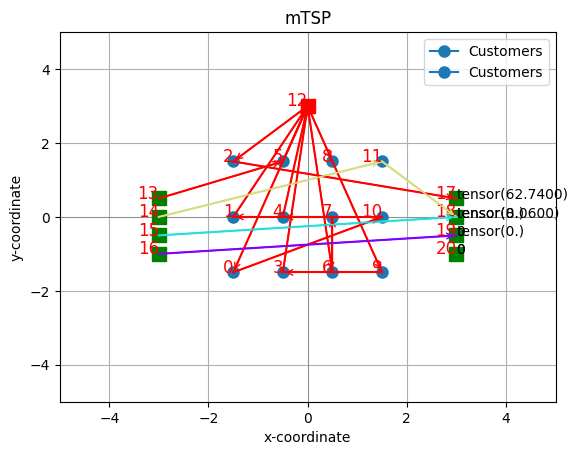

In [9]:
for td, actions in zip(td_eval, out['actions'].cpu()):
    print(actions)
    fig = env.render(td, actions)
    fig.show()

In [10]:
"""
1: <0> (13(D,0) 6(C,0) 0(C,0) 12(R,300) 17(D,0) ) cost = 772 , 
2: <1> (14(D,0) 7(C,0) 1(C,0) 8(C,0) 2(C,0) 9(C,0) 3(C,0) 12(R,300) 18(D,0) ) cost = 2539 , 
3: <2> (15(D,0) 12(R,300) 10(C,0) 
4(C,0) 11(C,0) 5(C,0) 19(D,0) ) cost = 2196 ,"""

'\n1: <0> (13(D,0) 6(C,0) 0(C,0) 12(R,300) 17(D,0) ) cost = 772 , \n2: <1> (14(D,0) 7(C,0) 1(C,0) 8(C,0) 2(C,0) 9(C,0) 3(C,0) 12(R,300) 18(D,0) ) cost = 2539 , \n3: <2> (15(D,0) 12(R,300) 10(C,0) \n4(C,0) 11(C,0) 5(C,0) 19(D,0) ) cost = 2196 ,'

Agent 1: (-3, 0.5) -> (0.5, -1.5) in 0.0010000000474974513
Agent 1: (0.5, -1.5) -> (-1.5, -1.5) in 0.3409999907016754
Agent 1: (-1.5, -1.5) -> (0, 3.0) in 0.38499999046325684
Agent 1: (0, 3.0) -> (3, 0.5) in 0.04500000178813934
Agent 2: (-3, 0.0) -> (0.5, 0.0) in 0.0010000000474974513
Agent 2: (0.5, 0.0) -> (-1.5, 0.0) in 0.34700000286102295
Agent 2: (-1.5, 0.0) -> (0.5, 1.5) in 0.37400001287460327
Agent 2: (0.5, 1.5) -> (-1.5, 1.5) in 0.3400000035762787
Agent 2: (-1.5, 1.5) -> (1.5, -1.5) in 0.367000013589859
Agent 2: (1.5, -1.5) -> (-0.5, -1.5) in 0.45500001311302185
Agent 2: (-0.5, -1.5) -> (0, 3.0) in 0.5820000171661377
Agent 2: (0, 3.0) -> (3, 0.0) in 0.0729999989271164
Agent 3: (-3, -0.5) -> (0, 3.0) in 0.10100000351667404
Agent 3: (0, 3.0) -> (1.5, 0.0) in 0.15600000321865082
Agent 3: (1.5, 0.0) -> (-0.5, 0.0) in 0.460999995470047
Agent 3: (-0.5, 0.0) -> (1.5, 1.5) in 0.4880000054836273
Agent 3: (1.5, 1.5) -> (-0.5, 1.5) in 0.45399999618530273
Agent 3: (-0.5, 1.5) -> (3, -0.5) i

C:\Users\zm0714\AppData\Local\Temp\ipykernel_30576\1744662953.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


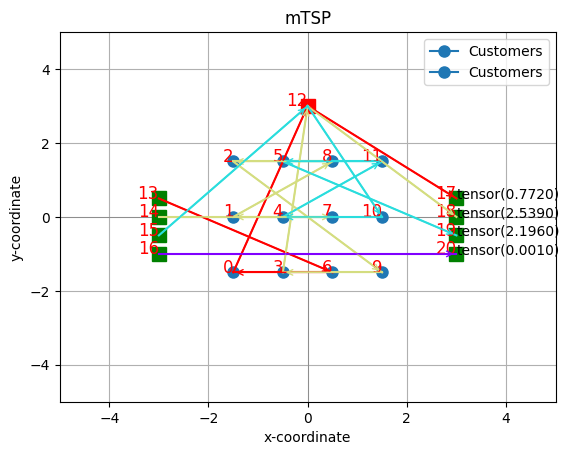

In [13]:
actions = torch.tensor([6, 0, 12, 17, 7, 1, 8, 2, 9, 3, 12, 18, 12, 10, 4, 11, 5, 19, 20])
# td_eval = env.reset(batch_size=[batch_size]).to("cpu")
fig = env.render(td_eval[0], actions)
fig.show()

In [122]:
TIME_WINDOWS = [
    (0, 500),
    (0, 10),  # location 2
    (0, 15),  # location 3
    (0, 20),  # location 4
    (0, 25),    # location 5
    (0, 30),   # location 6
    (0, 30),    # location 7
    (0, 30),   # location 8
    (0, 30),    # location 9
    (0, 30),  # location 10
    (0, 30),  # location 11
    (0, 30),    # location 12
]

In [16]:
td_init = env.reset(batch_size=[4]).to("cpu")
td = td_init[0].clone()
cm = torch.tensor(cost_matrix).float()
em = torch.tensor(energy_matrix).float()
td["cost_matrix"] = normalize_coord(cm)
td["energy_consumption"] = normalize_coord(em)

In [17]:
cost_matrix

array([[  0., 558., 523., 611., 590., 554., 341., 368., 396., 423., 451.,
        479., 385.,   0.,   0.,   0.,   0., 341., 368., 396., 423.],
       [613.,   0., 557., 645., 623., 588., 374., 347., 374., 402., 429.,
        457., 419.,   0.,   0.,   0.,   0., 374., 347., 374., 402.],
       [634., 612.,   0., 665., 644., 609., 395., 367., 340., 367., 395.,
        422., 440.,   0.,   0.,   0.,   0., 395., 367., 340., 367.],
       [777., 755., 720.,   0., 786., 751., 537., 510., 482., 455., 482.,
        510., 582.,   0.,   0.,   0.,   0., 537., 510., 482., 455.],
       [810., 789., 754., 842.,   0., 785., 571., 543., 516., 488., 461.,
        488., 616.,   0.,   0.,   0.,   0., 571., 543., 516., 488.],
       [831., 809., 774., 862., 841.,   0., 592., 564., 536., 509., 481.,
        454., 637.,   0.,   0.,   0.,   0., 592., 564., 536., 509.],
       [341., 362., 397., 598., 577., 542.,   0., 607., 635., 663., 690.,
        718., 538.,   0.,   0.,   0.,   0., 580., 607., 635., 663.],

In [18]:
from copy import deepcopy
td_init = env.reset(batch_size=[4])
# td = deepcopy(td_init[3])
# cm = torch.tensor(cost_matrix).float()
# em = torch.tensor(energy_matrix).float()
# td["cost_matrix"] = normalize_coord(cm)
# td["energy_consumption"] = normalize_coord(em)

# DURATION_MATRIX = td["cost_matrix"].detach().cpu().numpy()
DURATION_MATRIX = cost_matrix
num_agents = td["num_agents"].numpy()
num_points = td["customer_nodes"].shape[-1]
# locs = td["locs"]

cols = int(np.ceil(np.sqrt(num_points)))
rows = int(np.ceil(num_points / cols))

# Generate the rectangular spread coordinates
rectangular_spread = [(x, y) for x in np.linspace(
    -1.5, 1.5, cols) for y in np.linspace(-1.5, 1.5, rows)]
rectangular_spread = rectangular_spread[:num_points]
max_coord = max(rectangular_spread)
y_cs = max_coord[0] + 1.5
# Limit to the number of points needed
top_point = [(0, y_cs)]

y_values = np.linspace(0.5, -1, num_agents)
left_points = [(-3, y) for y in y_values]  # Points going down on the left
right_points = [(3, y) for y in y_values]
# Updating all points
all_points = rectangular_spread + top_point + left_points + right_points

In [19]:
#TIME_WINDOWS = td["time_windows"][0:12].detach().cpu().numpy()

In [20]:
m = Model()

In [21]:
depots = []
for idx in range(num_agents):
    depot_start = m.add_depot(x=left_points[idx][0], y=right_points[idx][1])
    print(depot_start)
    depot_end = m.add_depot(x=right_points[idx][0], y=right_points[idx][1])
    # Two vehicles at each depot, with 30 maximum route duration.
    m.add_vehicle_type(
        1,
        start_depot=depot_start,
        end_depot=depot_end,
        # max_duration=20,
        # tw_early=0,
        # tw_late=30,
    )
    depots.append(depot_start)
    depots.append(depot_end)

In [22]:
# for idx in range(len(rectangular_spread)):
#     m.add_client(
#         x=rectangular_spread[idx][0],
#         y=rectangular_spread[idx][1],
#         # tw_early=TIME_WINDOWS[idx][0],
#         # tw_late=TIME_WINDOWS[idx][1],
#     )
clients = [m.add_client(
        x=rectangular_spread[idx][0],
        y=rectangular_spread[idx][1],
        # tw_early=TIME_WINDOWS[idx][0],
        # tw_late=TIME_WINDOWS[idx][1],
    ) for idx in range(len(rectangular_spread))]

In [23]:
# DURATION_MATRIX *= 10

In [24]:
# customers = m.locations[8:]

In [25]:
# depots = m.locations[0:8]

In [26]:
locations = clients + depots 

In [27]:
for frm_idx, frm in enumerate(locations):
    for to_idx, to in enumerate(locations):
        distance = DURATION_MATRIX[frm_idx][to_idx] 
        duration = DURATION_MATRIX[frm_idx][to_idx]
        m.add_edge(frm, to, distance=distance, duration=duration)

In [28]:
res = m.solve(stop=MaxRuntime(5), display=False)  # one second
print(res)

Solution results
    # routes: 2
   # clients: 12
   objective: 4123
    distance: 4123
    duration: 4123
# iterations: 17769
    run-time: 5.00 seconds

Routes
------
Route #1: 14 8 15 9 16 10 17 11 
Route #2: 18 12 19 13 



In [44]:
res.best.routes()[0].visits()

[14, 8, 15, 9, 16, 10, 17, 11]

In [45]:
res.best.routes()[0].start_depot()

0

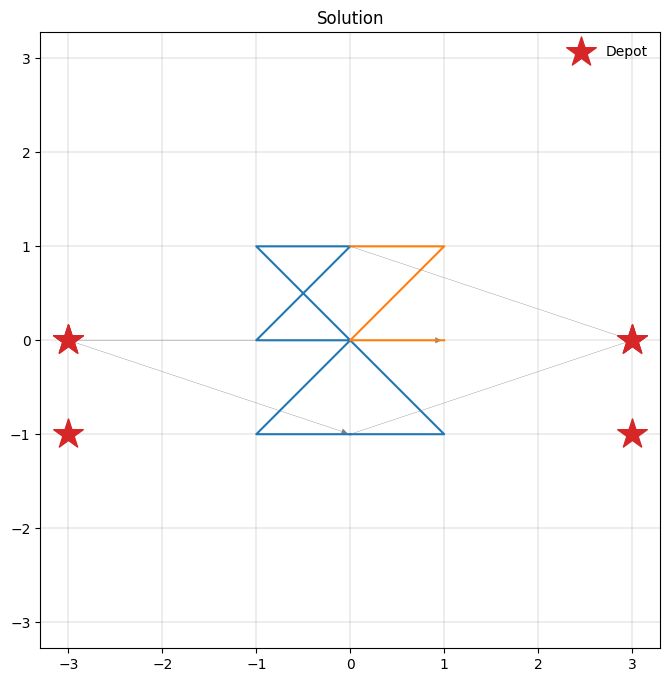

In [46]:
import matplotlib.pyplot as plt
from pyvrp.plotting import plot_solution
_, ax = plt.subplots(figsize=(8, 8))
plot_solution(res.best, m.data(), ax=ax)

In [87]:
COORDS = [
    (456, 320),  # location 0 - the depot
    (228, 0),    # location 1
    (912, 0),    # location 2
    (0, 80),     # location 3
    (114, 80),   # location 4
    (570, 160),  # location 5
    (798, 160),  # location 6
    (342, 240),  # location 7
    (684, 240),  # location 8
    (570, 400),  # location 9
    (912, 400),  # location 10
    (114, 480),  # location 11
    (228, 480),  # location 12
    (342, 560),  # location 13
    (684, 560),  # location 14
    (0, 640),    # location 15
    (798, 640),  # location 16
]
DEMANDS = [0, 1, 1, 2, 4, 2, 4, 8, 8, 1, 2, 1, 2, 4, 4, 8, 8]

TIME_WINDOWS = [
    (0, 999),  # location 0 - a depot (modified to be unrestricted)
    (0, 999),  # location 1 - a depot (modified to be unrestricted)
    (10, 15),  # location 2
    (16, 18),  # location 3
    (10, 13),  # location 4
    (0, 5),    # location 5
    (5, 10),   # location 6
    (0, 4),    # location 7
    (5, 10),   # location 8
    (0, 3),    # location 9
    (10, 16),  # location 10
    (10, 15),  # location 11
    (0, 5),    # location 12
    (5, 10),   # location 13
    (7, 8),    # location 14
    (10, 15),  # location 15
    (11, 15),  # location 16
]

m = Model()

for idx in range(2):
    depot = m.add_depot(x=COORDS[idx][0], y=COORDS[idx][1])

    # Two vehicles at each depot, with 30 maximum route duration.
    m.add_vehicle_type(
        2,
        start_depot=depot,
        end_depot=depot,
        max_duration=30,
        tw_early=TIME_WINDOWS[idx][0],
        tw_late=TIME_WINDOWS[idx][1],
    )

for idx in range(2, len(COORDS)):
    m.add_client(
        x=COORDS[idx][0],
        y=COORDS[idx][1],
        tw_early=TIME_WINDOWS[idx][0],
        tw_late=TIME_WINDOWS[idx][1],
    )

for frm_idx, frm in enumerate(m.locations):
    for to_idx, to in enumerate(m.locations):
        distance = abs(frm.x - to.x) + abs(frm.y - to.y)  # Manhattan
        duration = DURATION_MATRIX[frm_idx][to_idx]
        m.add_edge(frm, to, distance=distance, duration=duration)

In [88]:
res = m.solve(stop=MaxRuntime(1), display=False)  # one second
print(res)

Solution results
    # routes: 4
   # clients: 15
   objective: INFEASIBLE
    distance: 12416
    duration: 322
# iterations: 814
    run-time: 1.00 seconds

Routes
------
Route #1: 11 5 8 14 
Route #2: 10 3 2 4 
Route #3: 15 13 9 16 
Route #4: 7 12 6 



In [29]:
# Copyright (c) 2023 Patrick S. Klein (@libklein)
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

import copy

import routingblocks as rb
import random


def create_random_solution(evaluation: rb.Evaluation, instance: rb.Instance):
    customer_vertex_ids = [x.vertex_id for x in instance.customers]
    random.shuffle(customer_vertex_ids)

    # Draw a sequence of positions where to split
    number_of_splits = random.randint(1, len(customer_vertex_ids) // 2)
    split_positions = [0, *sorted(random.sample(range(1, len(customer_vertex_ids) - 1), number_of_splits)),
                       len(customer_vertex_ids)]
    # Create routes according to the split positions. Each route is a list of customer vertex ids.
    routes = [customer_vertex_ids[route_start_index:route_end_index] for route_start_index, route_end_index in
              zip(split_positions, split_positions[1:])]
    # Create RoutingBlocks Route objects
    routes = [rb.create_route(evaluation, instance, route) for route in routes]
    # Create RoutingBlocks Solution object
    return rb.Solution(evaluation, instance, routes)


def perturb(solution: rb.Solution, max_exchanges: int) -> rb.Solution:
    assert sum(1 for r in solution if not r.empty) > 1, "Cannot perturb a solution with only one route."
    # Create a new solution by copying the current solution
    new_solution = copy.copy(solution)

    # Exchange random sequences between routes
    num_exchanges = random.randint(0, max_exchanges)
    for _ in range(num_exchanges):
        # Select two random routes
        while True:
            route_1 = random.choice(new_solution)
            route_2 = random.choice(new_solution)
            if route_1 is not route_2 and not route_1.empty and not route_2.empty:
                break
        # Select a random sequence of customers in route 1 that does not include the depot
        start_index_1 = random.randint(1, len(route_1) - 2)
        # end_index is exclusive
        end_index_1 = random.randint(start_index_1, len(route_1) - 1)
        # Do the same for the second route
        # Select a random sequence of customers in route 1 that does not include the depot
        start_index_2 = random.randint(1, len(route_2) - 2)
        # end_index is exclusive
        end_index_2 = random.randint(start_index_2, len(route_2) - 1)
        # Exchange the sequences
        new_solution.exchange_segment(route_1, start_index_1, end_index_1,
                                      route_2, start_index_2, end_index_2)
    return new_solution


def iterated_local_search(instance: rb.Instance, vehicle_storage_capacity: float, vehicle_battery_capacity_time: float,
                          number_of_iterations: int = 100):
    evaluation = rb.adptw.Evaluation(vehicle_battery_capacity_time, vehicle_storage_capacity)
    # Set the penalty factors used to penalize violations of the time window, the
    # vehicle capacity, and the charge constraints
    evaluation.overload_penalty_factor = 100.
    evaluation.resource_penalty_factor = 100.0
    evaluation.time_shift_penalty_factor = 100.0

    # Configure the local search to use a best-improvement pivoting rule
    local_search = rb.LocalSearch(instance, evaluation, None, rb.BestImprovementPivotingRule())
    # Create a set of allowed arcs
    arc_set = rb.ArcSet(instance.number_of_vertices)

    # Create a set of operators that will be used later when calling the local search
    operators = [
        rb.operators.SwapOperator_0_1(instance, arc_set),
        rb.operators.SwapOperator_1_1(instance, arc_set),
        rb.operators.InsertStationOperator(instance),
        rb.operators.RemoveStationOperator(instance),
    ]

    best_solution = create_random_solution(evaluation, instance)
    current_solution = copy.copy(best_solution)
    for i in range(number_of_iterations):
        # Search the neighborhood of the current solution. This modifies the solution in-place.
        local_search.optimize(current_solution, operators)
        if current_solution.cost < best_solution.cost:
            best_solution = current_solution
            print(f"New best solution found: {best_solution.cost} ({best_solution.feasible})")

        # Perturb the current solution
        current_solution = perturb(current_solution, len(current_solution) // 2)

    return best_solution

In [30]:
from typing import Callable, Dict, Union
from pathlib import Path
from itertools import product
from math import sqrt
import routingblocks as rb


def parse_instance(instance_path: Path):
    str_fields = ['StringID', 'Type']
    with open(instance_path) as instance_stream:
        fields = instance_stream.readline().split()
        # Parse the vertices
        vertices = []
        for line in instance_stream:
            tokens = line.split()
            if len(tokens) == 0:
                break
            # Read columns into a dictionary
            vertex = {key: (x if key in str_fields else float(x)) for key, x in zip(fields, tokens)}
            vertices.append(vertex)
        # Parse the parameters
        parameters = {}
        for line in instance_stream:
            key, *_, value = line.split()
            # Remove surrounding / characters and parse the value
            parameters[key] = float(value[1:-1])

    # Create a mapping from pairs of vertices to arcs
    arcs = {}
    for i in vertices:
        for j in vertices:
            # Compute distance
            distance = sqrt((i['x'] - j['x']) ** 2 + (i['y'] - j['y']) ** 2)
            # Compute travel time (distance / average velocity)
            travel_time = distance / parameters['v']
            # Compute consumption (consumption rate * travel time / recharging rate)
            consumption = parameters['r'] * travel_time / parameters['g']
            arcs[i['StringID'], j['StringID']] = dict(distance=distance, travel_time=travel_time,
                                                      consumption=consumption)

    return vertices, arcs, parameters


def create_instance(serialized_vertices, serialized_arcs) -> rb.Instance:
    instance_builder = rb.utility.InstanceBuilder(create_vertex=rb.adptw.create_adptw_vertex,
                                                  create_arc=rb.adptw.create_adptw_arc)
    # instance_builder.fleet_size = 1
    # Create and register the vertices
    for vertex in serialized_vertices:
        # Create problem-specific data held by vertices
        vertex_data = rb.adptw.VertexData(vertex['x'], vertex['y'], vertex['demand'], vertex['ReadyTime'],
                                          vertex['DueDate'],
                                          vertex['ServiceTime'])
        # Register the vertex depending on it's type
        if vertex['Type'] == 'd':
            instance_builder.set_depot(vertex['StringID'], vertex_data)
        elif vertex['Type'] == 'c':
            instance_builder.add_customer(vertex['StringID'], vertex_data)
        else:
            instance_builder.add_station(vertex['StringID'], vertex_data)

    # Create and register the arcs
    for (i, j), arc in serialized_arcs.items():
        # Create problem-specific data held by arcs
        arc_data = rb.adptw.ArcData(arc['distance'], arc['consumption'], arc['travel_time'])
        instance_builder.add_arc(i, j, arc_data)

    # Create instance
    return instance_builder.build()

In [31]:
from pathlib import Path
import argparse

def solve(instance_path: Path, number_of_iterations: int = 100):
    vertices, arcs, params = parse_instance(instance_path)
    instance = create_instance(vertices, arcs)
    vehicle_storage_capacity = params['C']
    # Vehicle battery capacity in units of time:
    # battery capacity * inverse refueling rate = battery capacity / refueling rate
    vehicle_battery_capacity_time = params['Q'] * params['g']

    solution = iterated_local_search(instance=instance, vehicle_storage_capacity=vehicle_storage_capacity,
                                     vehicle_battery_capacity_time=vehicle_battery_capacity_time,
                                     number_of_iterations=number_of_iterations
                                     )

    print("Best solution:")
    print(solution)
    return solution





In [32]:
# parser = argparse.ArgumentParser(description="Solve a EVRP-TW-PR instance with ILS.")
# 
# parser.add_argument(
#     "instance_path",
#     type=Path,
#     help="Path to the instance file."
# )
# 
# parser.add_argument(
#     "-n", "--number_of_iterations",
#     type=int,
#     default=100,
#     help="Number of ILS iterations to perform (default: 100)."
# )
# 
# args = parser.parse_args()

sol = solve("./instance/c101_21_25.txt", 200)  

New best solution found: 619.1160888671875 (True)
Best solution:
Solution(cost=619.116, routes=[[D0,C58,C50,D0,]
[D0,C65,C73,C81,C61,D0,]
[D0,D0,]
[D0,C90,C82,C85,C91,D0,]
[D0,D0,]
[D0,C2,C6,C9,D0,]
[D0,D0,]
[D0,C16,C18,C15,D0,]
[D0,C21,C24,C25,C32,C39,C26,D0,]
[D0,C94,C97,C100,D0,]
[D0,D0,]
])


In [7]:
sol.routes

In [31]:
vertices, arcs, params = parse_instance("./instance/c101_21.txt")
instance = create_instance(vertices, arcs)